# 투빅스 15기 정규세션 10주차 DCGAN 구현 주석달기 과제
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드입니다.  
위 코드나  아래 코드에 주석을 자유롭게 한글로 달아주시면 됩니다.   
단, # ( ... ) 와 같은 표식이 있는 라인에는 꼭 주석을 달아주세요 !  
튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋습니다. 
또한, 잘 모르는 메서드의 경우 파이토치 공식 docs의 설명을 참고하시면 됩니다.
https://pytorch.org/docs/stable/index.html

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64   # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize),   # 주어진 이미지 크기 조절 (28X28 -> 64X64) (imageSize = Desired output size)
                                                     transforms.ToTensor(),   # Tensor로 변환
                                                     transforms.Normalize((0.5,), (0.5,)),   # 노말라이즈를 통해 -1.~1.의 값을 갖도록 변환
                     ]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset))     # 데이터 수 확인
image, _ = dataset[0]     # 데이터는 (이미지, label) 

print('Image')
print('========================================')
print('shape of this image\t:', image.shape)     # 데이터 차원(모양) 확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


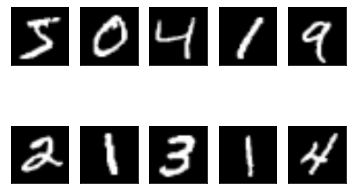

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image, _ = dataset[i]   # 데이터셋에서 이미지만 불러오기
    image = (image+1)/2   # 0과 1 사이로 변경 (transforms.Normalize()를 통해 -1.~1. 사이로 정규화된 상태에서, 왼쪽 코드 시행하면 0.~1. 사이의 값을 갖게 됨)
    image = image.squeeze()   # 사이즈가 1인 차원을 제거한 후, Tensor를 반환 (이때, dim 파라미터를 지정하지 않았으므로 사이즈가 1인 모든 차원은 제거됨)
    np_img = image.numpy()   # numpy array로 변경
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128   # 논문과 동일하게
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True,   # 각 epoch마다 데이터가 reshuffle
                                         num_workers = workers)   # 데이터 로드 시 2개의 서브 프로세스 사용

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   # cuda가 사용 가능하면 device에 cuda 설정 (GPU 사용 가능 시 GPU 사용, 그렇지 않다면 CPU 사용)
print(device)

cuda:0


## 신경망 

In [ ]:
# 네트워크 하이퍼파라미터 설정
nc = 1   # number of channels in the training images (흑백)
nz = 100   # size of z latent vector (논문과 동일)

# 64x64 이미지.
ngf = 64   # size of feature maps in generator
ndf = 64   # size of feature maps in discriminator 

### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:   # Convolution 레이어라면,
        nn.init.normal_(m.weight.data, 0.0, 0.02)   # 가중치(weight)를 평균이 0이고 표준편차가 0.02인 정규분포에서 뽑은 값으로 초기화
    elif classname.find('BatchNorm') != -1:   # Batch Normalization의 경우,
        nn.init.normal_(m.weight.data, 1.0, 0.02)   # 먼저 가중치를 평균이 1이고 표준편차가 0.02인 정규분포에서 뽑은 값으로 초기화한 후,
        nn.init.constant_(m.bias.data, 0)   # 편차(bias)를 0으로 초기화. 참고 : m.bias.data.fill_(0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

이미지 출처 : DCGAN TUTORIAL

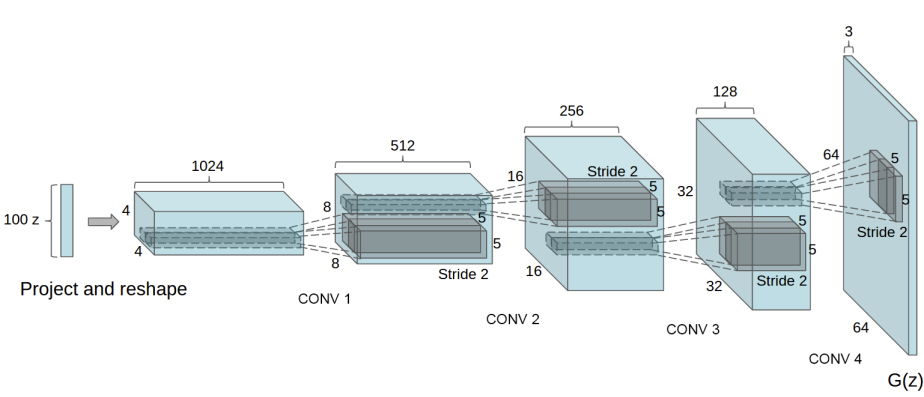

In [ ]:
class Generator(nn.Module):   # 해당 논문의 그림과는 feature map이 다르지만 feature map을 64로 설정했으므로 이를 따른다.
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z(또는 nz)를 input으로 하여 TransposedConV를 거쳐, 이미지로 변환된다. 
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False ),   # input channel, output channel, filter size, stride, padding --> 크기는 논문과 동일하게
            nn.BatchNorm2d(ngf * 8),   # 배치 정규화
            nn.ReLU(True),   # 생성자는 output 제외 모두 ReLU를 사용한다.
            # 크기 : (ngf*8) * 4 * 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),   # 이미지 크기는 2배로 늘리고, channel은 0.5배로 줄이고, stride는 논문과 동일하게.
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 크기 : (ngf*4) * 8 * 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 크기 : (ngf*2) * 16 * 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 크기 : ngf * 32 * 32
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 크기 : nc * 64 * 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device)   # 생성자 객체 생성
netG.apply(weights_init)   # 가중치 초기화 (위에서 정의한 weights_init(m) 함수 이용)

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


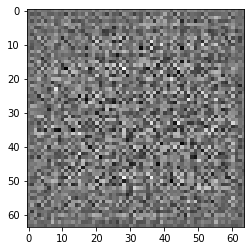

In [ ]:
# 생성자 테스트
test_data=dataloader.dataset[0] 
noise=torch.randn(1, nz, 1, 1, device=device)    # (1, 100, 1, 1) 크기의 노이즈(위에서 nz = 100으로 지정)

test_image=netG(noise)   # 테스트용 이미지 생성 (input으로 noise 활용)

# 1. .squeeze() : 사이즈가 1인 차원을 제거한 후, Tensor를 반환
# 2. .cpu() : 현재 object(이 경우, Tensor)를 CPU 메모리에 복사
# 3. .detach() : 현재 graph에서 분리하여 새로운 Tensor를 반환 (현재까지 추적된 모든 연산 과정으로부터 detach)
# 4. .numpy() : Tensor를 NumPy의 ndarray로 반환 (이때, Tensor와 ndarray는 같은 storage를 공유하므로 하나가 바뀌면 다른 하나도 바뀜)
test_image=test_image.squeeze().cpu().detach().numpy()

plt.imshow(test_image, cmap = 'gray')

위의 코드로 하여금 가중치 초기화가 된 상태.

### 판별자 클래스

In [ ]:
class Discriminator(nn.Module):   # 생성자와 반대로 진행하면 된다.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential( 
            # input : (nc) x 64 x 64 의 이미지 - 여기서는 nc=1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # (...)
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: ndf * 32 * 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),   # 이미지 크기는 0.5배로, 채널의 크기는 2배로. (생성자와 반대)
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*2) * 16 * 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*4) * 8 * 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*8) * 4 * 4
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 판별자 객체 생성
netD.apply(weights_init)   # 가중치 초기화 (위에서 정의한 weights_init(m) 함수 이용)

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# 판별자 테스트
test_image=netG(noise)
netD(test_image)

tensor([[[[0.6919]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

아직 학습이 안 되긴 했지만, 위의 생성 이미지는 가짜 이미지로 판단할 것

## Loss Function & Optimizer

In [ ]:
# optimizer hyperparameters
criterion = nn.BCELoss()   # Loss function으로 Binary Cross Entropy를 사용 (진짜인지 가짜인지 판별하는 binary case이므로)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)   # 학습 과정을 보기 위한 노이즈.

# 진짜 데이터와 가짜 데이터에 대한 라벨 설정 (Training 단계에서)
real_label = 1.   # 진짜(real) 데이터는 라벨을 1로 설정
fake_label = 0.   # 가짜(fake) 데이터는 라벨을 0으로 설정

# optimizer hyperparameters
learning_rate = 2e-4   # 논문과 동일
beta1 = 0.5   # Adam optimizer의 하이퍼파라미터, 논문과 동일

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Train
각각의 변수 및 메소드가 무엇을 나타내는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

### 특정 method에 대해 어떤 역할을 하는 지 간단히 적어주세요.  
torch.Tensor.view() : NumPy의 reshape와 같은 역할을 한다. 즉, Tensor의 크기를 변경하는 역할.

torch.Tensor.item() : 단일값을 포함하고 있는 Tensor로부터 standard Python number를 추출하는 역할. ('standard Python number'은 공식 문서의 표현인데, 단순히 scalar로 이해해도 무방해보인다.)

torch.Tensor.detach() : 현재의 graph에서 Tensor를 분리하여 반환하는데, netG에 적용해보면 netG에 역전파가 이루어지지 않게끔 하는 역할.

torch.Tensor.squeeze() : 사이즈가 1인 차원을 제거한 후, 새로운 Tensor를 반환하는 역할.

torch.Tensor.unsqueeze() : 지정한 위치에 1차원을 삽입한 후, 새로운 Tensor를 반환하는 역할.

In [ ]:
num_epochs = 5   # 더 늘리셔도 됩니다.

# 학습 과정 저장
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ########################
        # (1) 판별자(D) 업데이트 : 식 log(D(x)) + log(1 - D(G(z))) 를 최대화한다.
        ########################
        # 즉, 기존 이미지인 x를 진짜(1)로 판별하고
        # 생성 이미지인 G(z)를 가짜(0)으로 판별

        ## 진짜 이미지에 대한 학습

        netD.zero_grad()   # Training 단계에서, 각 batch마다 역전파 수행 전 기울기(gradients)를 초기화해야 함 (파이토치는 gradients를 누적하므로)
        # batch 초기화
        real_cpu = data[0].to(device)   # 진짜 이미지 데이터를 device(GPU)에 올리기
        b_size = real_cpu.size(0)   # batch size.
        # torch.full(size, fill_value)는 fill_value로 채워진 size 크기의 Tensor를 만듦
        # 따라서 label은 1(real_label)로 채워진 b_size 크기의 Tensor
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)   
        
        # real_cpu를 netD에 통과시킨 결과를 output으로 정의, 이후 output을 flatten(view(-1))하여 1차원 Tensor로 반환
        output = netD(real_cpu).view(-1)
        # output에 대한 loss 계산
        errD_real = criterion(output, label)   # label : (batch x 1)
        # real batch에 대한 netD의 역전파 계산 후, output에 대한 평균을 scalar로 추출
        errD_real.backward()
        D_x = output.mean().item() 

        ## 가짜 이미지에 대한 학습

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # netG로 가짜 이미지 batch 생성 (input으로 noise 활용)
        fake = netG(noise)
        # 1로 채워져있었던 label을 0(fake_label)으로 채움
        label.fill_(fake_label) 
        # netD를 활용해 가짜 이미지를 분류, 이후 결과를 1차원 Tensor로 반환
        # 이때 fake에 대한 역전파 누적 방지를 위해 .detach() method 활용
        output = netD(fake.detach()).view(-1)
        # output에 대한 loss 계산
        errD_fake = criterion(output, label)
        # fake batch에 대한 netD의 역전파 계산 후, output에 대한 평균을 scalar로 추출
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 진짜 이미지, 가짜 이미지에 대한 loss를 합한다 - 목표 : argmax(logD(x), log(1-D(G(z))))
        errD = errD_real + errD_fake   # total loss
        # 판별자(D) 업데이트
        optimizerD.step()

        ########################
        # (2) 생성자(G) 업데이트 : log(D(G(z))) 를 최대화한다.
        ########################

        netG.zero_grad()
        label.fill_(real_label)   # netG(Generator)는 netD가 가짜 이미지를 1로 판별할 확률을 최대화시키는 것이 목적이므로, label을 1로 채운 후 loss 계산해야 함
        # D만 업데이트 된 상태이므로 다시 판별자(D)에 가짜 이미지를 통과.
        output = netD(fake).view(-1)
        # output에 대한 netG의 loss 계산
        errG = criterion(output, label)
        # netG의 역전파 계산 후, output에 대한 평균을 scalar로 추출
        errG.backward()
        D_G_z2 = output.mean().item()
        # 생성자(G) 업데이트
        optimizerG.step()

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # loss history 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # noise가 고정되어있을 때 생성자(G)가 생성하는 image history 저장
        # 더 자주 이미지를 저장하고 싶은 경우 아래 코드 수정(e.g., 500 -> 200)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/469]	Loss_D: 2.6487	Loss_G: 2.0037	D(x): 0.2248	D(G(z)): 0.4627 / 0.1756
[0/5][50/469]	Loss_D: 0.0069	Loss_G: 12.8503	D(x): 0.9937	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.2257	Loss_G: 6.2495	D(x): 0.9137	D(G(z)): 0.0983 / 0.0040
[0/5][150/469]	Loss_D: 0.0840	Loss_G: 4.8817	D(x): 0.9682	D(G(z)): 0.0438 / 0.0140
[0/5][200/469]	Loss_D: 0.1752	Loss_G: 5.5872	D(x): 0.9563	D(G(z)): 0.0962 / 0.0092
[0/5][250/469]	Loss_D: 0.1733	Loss_G: 3.9450	D(x): 0.9188	D(G(z)): 0.0718 / 0.0299
[0/5][300/469]	Loss_D: 0.1396	Loss_G: 3.1777	D(x): 0.8974	D(G(z)): 0.0186 / 0.0661
[0/5][350/469]	Loss_D: 0.1253	Loss_G: 3.8006	D(x): 0.9287	D(G(z)): 0.0432 / 0.0349
[0/5][400/469]	Loss_D: 0.1887	Loss_G: 3.6464	D(x): 0.8766	D(G(z)): 0.0271 / 0.0503
[0/5][450/469]	Loss_D: 0.1307	Loss_G: 3.9295	D(x): 0.9002	D(G(z)): 0.0162 / 0.0354
[1/5][0/469]	Loss_D: 2.8083	Loss_G: 2.0470	D(x): 0.9094	D(G(z)): 0.8609 / 0.2038
[1/5][50/469]	Loss_D: 0.5298	Loss_G: 2.4186	D(x): 0.7787	D(G(z)): 0.1970 / 0.1190
[1/5][100

## Loss에 대한 설명을 해주세요.
- Loss_D : Discriminator(netD)의 total loss
- Loss_G : Generator(netG)의 total loss
- D(x) : 진짜 이미지에 대한 Discriminator의 평균 output. 이때 real_label을 1로 설정했으므로, 처음에는 1에 가깝다가 Generator의 성능이 향상함에 따라 0.5로 수렴하게 됨.
- D(G(z)) : 가짜 이미지에 대한 Discriminator의 평균 output. 이때 fake_label을 0으로 설정했으므로, 처음에는 0에 가깝다가 Generator의 성능이 향상함에 따라 0.5로 수렴하게 됨.


# 결과

### 학습 과정에서 변하는 Loss 해석하기
> 참고하면 좋은 사이트 : https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

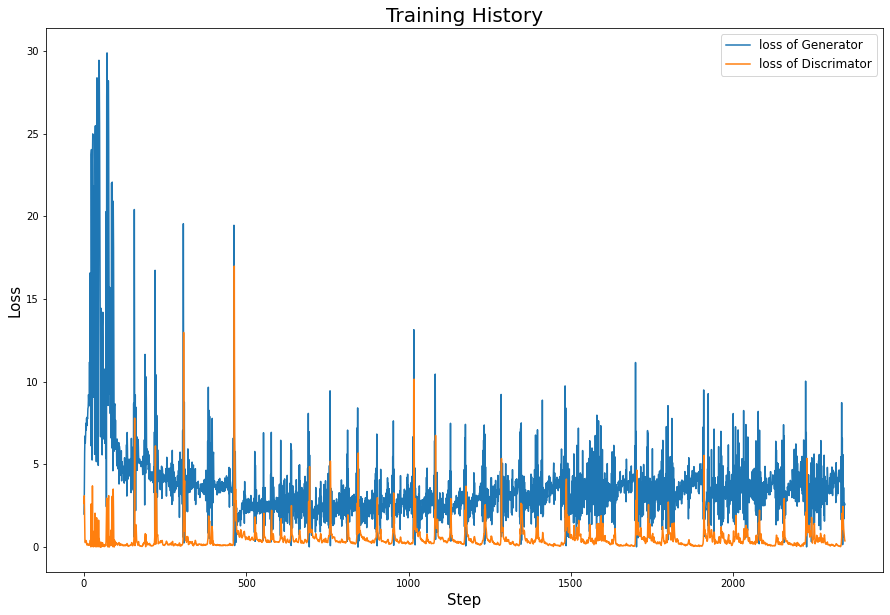

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Training History', fontsize=20)
plt.plot(G_losses, label='loss of Generator')
plt.plot(D_losses, label='loss of Discrimator')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(fontsize=12)

음.. 초반에는 Generator 성능이 안 좋은 반면, Discrimator가 가짜와 진짜를 잘 구별하는구나.. 중간에는 Discrimator도 갑자기 정신 못 차리고.. 왜저럴까.. 그래도 말미엔 둘의 사이가 좋아졌구나.. 1500 step 이후 그래프만 보면 어떨까? 진동할까?

해석 : 초반에는 Generator의 Loss에 비해 Discriminator의 Loss가 확연하게 낮으므로, Discriminator가 이미지 분류를 잘하고 있음을 알 수 있다. 다만, Step이 커질수록 Generator와 Discriminator가 함께 어느 정도 성능 개선을 보이고는 있으나, 학습이 눈에 띄게 진전되고 있다고는 보기 어렵다. 따라서, Step이 커지더라도 위 그래프는 안정적인 구조(수렴하는 구조)를 보이기보다는 경쟁적 학습의 결과로서 진동하는 형태가 계속 나타날 것으로 예상된다.

### 학습 과정에서 생성하는 이미지를 gif로 살펴보자.

In [ ]:
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

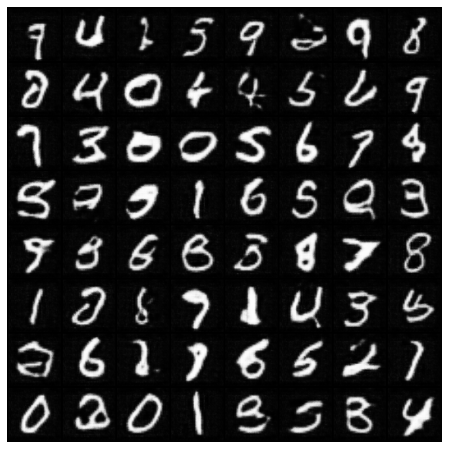

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

학습 데이터 셋 자체가 굉장히 간단하기 때문에 비교적 짧은 시간동안 학습했음에도 불구하고 나름대로 숫자와 비슷한 이미지를 생성했구나.. 학습을 더 오래하면 어떻게 될까? 1epoch 내에서도 모델이 천차만별로 달라질까? 그렇다면, 모델을 더 자주 저장할 필요도 있겠구나..

해석 : 위 데이터셋에서는 오히려 학습을 지속할수록 원본 이미지와의 유사도가 떨어지는 것으로 보이는데, 특정 데이터(숫자)에 치우쳐 이미지가 생성되는 Mode Collapsing 문제 때문이라고 생각된다. 따라서 epoch가 커질수록 생성 성능이 반드시 높아지는 것은 아니며, 데이터셋의 크기에 따라 적정 epoch를 설정할 필요가 있어 보인다.